## **HOMEWORK 4.2: Warehouse Robot Positioning** <br> <br>



In [49]:

# Required imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from typing import List, Tuple, Dict
import random
from copy import deepcopy

np.random.seed(42)
random.seed(42)

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


In [50]:
#Define Warehouse Setup

WAREHOUSE_SIZE = 100

# Fixed charging station positions
charging_stations = np.array([
    [20, 20],
    [80, 20],
    [50, 50],
    [20, 80],
    [80, 80]
])

NUM_STATIONS = len(charging_stations)
NUM_ROBOTS = 5

print(f"Warehouse Configuration:")
print(f"  Size: {WAREHOUSE_SIZE}m × {WAREHOUSE_SIZE}m")
print(f"  Charging stations: {NUM_STATIONS}")
print(f"  Robots to position: {NUM_ROBOTS}")
print(f"\nCharging Station Locations:")
for i, (x, y) in enumerate(charging_stations):
    print(f"  Station {i+1}: ({x:.0f}, {y:.0f})")

Warehouse Configuration:
  Size: 100m × 100m
  Charging stations: 5
  Robots to position: 5

Charging Station Locations:
  Station 1: (20, 20)
  Station 2: (80, 20)
  Station 3: (50, 50)
  Station 4: (20, 80)
  Station 5: (80, 80)


In [51]:
#Implement Fitness Funcion

def calculate_total_distance(robot_positions: np.ndarray, stations: np.ndarray) -> float:
    #For each robot find the distance to its nearest charging station

    total_distance = 0

    for robot_pos in robot_positions:
        #Calculate the distances from all stations:
        distances = np.sqrt(np.sum((stations - robot_pos)**2, axis=1))

        min_dist = np.min(distances)
        total_distance += min_dist
    
    return total_distance

# Test with random positions
test_positions = np.random.uniform(0, WAREHOUSE_SIZE, (NUM_ROBOTS, 2))
test_distance = calculate_total_distance(test_positions, charging_stations)
print(f"Test distance: {test_distance if test_distance else 'Not implemented yet'}")

Test distance: 88.1027998243607


In [52]:
#Implement PSO algorithm

class Particle:

    def __init__(self, dimension: int):
        #Position: random robot position in the warehouse
        self.position = np.random.uniform(0, WAREHOUSE_SIZE, dimension)
        #Velocity: random initial velocity
        self.velocity = np.random.uniform(-5, 5, dimension)
        #Personal best position
        self.best_position = self.position.copy()
        #Personal best fitness
        self.best_fitness = float('inf')


def particle_swarm_optimization(stations: np.ndarray,
                               num_particles: int = 30,
                               num_iterations: int = 100,
                               w: float = 0.7,
                               c1: float = 1.5,
                               c2: float = 1.5) -> Tuple[np.ndarray, List[float], List[np.ndarray]]:
    dimensions = NUM_ROBOTS * 2

    #Initialize swarm
    swarm = [Particle(dimensions) for _ in range(num_particles)]

    #Global best
    global_best_position = None
    global_best_fitness = float('inf')

    best_fitness_history = []
    swarm_history = []

    print("\nParticle Swarm Optimization Progress:")
    print("="*60)

    for iteration in range(num_iterations):
        
        # Evaluate fitness for all particles
        for particle in swarm:
            # Reshape position to (NUM_ROBOTS, 2)
            robot_positions = particle.position.reshape(NUM_ROBOTS, 2)
            fitness = calculate_total_distance(robot_positions, stations)
            
            # Update personal best
            if fitness < particle.best_fitness:
                particle.best_fitness = fitness
                particle.best_position = particle.position.copy()
            
            # Update global best
            if fitness < global_best_fitness:
                global_best_fitness = fitness
                global_best_position = particle.position.copy()
        
        best_fitness_history.append(global_best_fitness)
        
        # Store swarm positions for visualization (every 10 iterations)
        if iteration % 10 == 0:
            swarm_positions = np.array([p.position.reshape(NUM_ROBOTS, 2) for p in swarm])
            swarm_history.append(swarm_positions)
        
        # Print progress
        if iteration % 20 == 0 or iteration == num_iterations - 1:
            print(f"Iteration {iteration:3d}: Best fitness = {global_best_fitness:.2f}m")
             
        r1 = np.random.random(dimensions)
        r2 = np.random.random(dimensions)

        particle.velocity = (w * particle.velocity +
                             c1 * r1 * (particle.best_position - particle.position) +
                             c2 * r2 * (global_best_position - particle.position))   
        
        particle.position += particle.velocity

        particle.position = np.clip(particle.position, 0, WAREHOUSE_SIZE)
        
    print("="*60)
    print(f"\n✓ Optimization complete!")
    print(f"  Best total distance: {global_best_fitness:.2f}m")
    print(f"  Average distance per robot: {global_best_fitness/NUM_ROBOTS:.2f}m")
    
    best_position = global_best_position.reshape(NUM_ROBOTS, 2)
    return best_position, best_fitness_history, swarm_history

# Run PSO
best_robot_positions, fitness_history, swarm_history = particle_swarm_optimization(
    charging_stations,
    num_particles=30,
    num_iterations=100,
    w=0.7,
    c1=1.5,
    c2=1.5
)



Particle Swarm Optimization Progress:
Iteration   0: Best fitness = 40.50m
Iteration  20: Best fitness = 40.50m
Iteration  40: Best fitness = 32.80m
Iteration  60: Best fitness = 31.77m
Iteration  80: Best fitness = 31.70m
Iteration  99: Best fitness = 31.66m

✓ Optimization complete!
  Best total distance: 31.66m
  Average distance per robot: 6.33m


In [53]:
print("\n" + "="*60)
print("OPTIMAL ROBOT POSITIONS")
print("="*60)

# Find nearest station for each robot
for i, robot_pos in enumerate(best_robot_positions):
    distances = np.sqrt(np.sum((charging_stations - robot_pos)**2, axis=1))
    nearest_station = np.argmin(distances)
    min_distance = distances[nearest_station]
    
    print(f"\nRobot {i+1}: ({robot_pos[0]:.1f}, {robot_pos[1]:.1f})")
    print(f"  Nearest station: Station {nearest_station+1}")
    print(f"  Distance: {min_distance:.2f}m")

total_dist = calculate_total_distance(best_robot_positions, charging_stations)
avg_dist = total_dist / NUM_ROBOTS

print(f"\n{'='*60}")
print("PERFORMANCE METRICS")
print("="*60)
print(f"Total distance: {total_dist:.2f}m")
print(f"Average distance per robot: {avg_dist:.2f}m")

# Calculate initial random solution for comparison
initial_positions = np.random.uniform(0, WAREHOUSE_SIZE, (NUM_ROBOTS, 2))
initial_distance = calculate_total_distance(initial_positions, charging_stations)
improvement = ((initial_distance - total_dist) / initial_distance) * 100

print(f"\nRandom placement distance: {initial_distance:.2f}m")
print(f"Improvement: {improvement:.1f}%")


OPTIMAL ROBOT POSITIONS

Robot 1: (85.2, 82.0)
  Nearest station: Station 5
  Distance: 5.60m

Robot 2: (86.9, 95.5)
  Nearest station: Station 5
  Distance: 16.99m

Robot 3: (51.3, 50.0)
  Nearest station: Station 3
  Distance: 1.34m

Robot 4: (79.4, 80.0)
  Nearest station: Station 5
  Distance: 0.63m

Robot 5: (73.2, 77.9)
  Nearest station: Station 5
  Distance: 7.10m

PERFORMANCE METRICS
Total distance: 31.66m
Average distance per robot: 6.33m

Random placement distance: 72.38m
Improvement: 56.3%


4
5.600044011723412
80
4
16.991436833351045
80
2
1.3441573400597195
50
4
0.6302757994660275
80
4
7.097135367745689
80


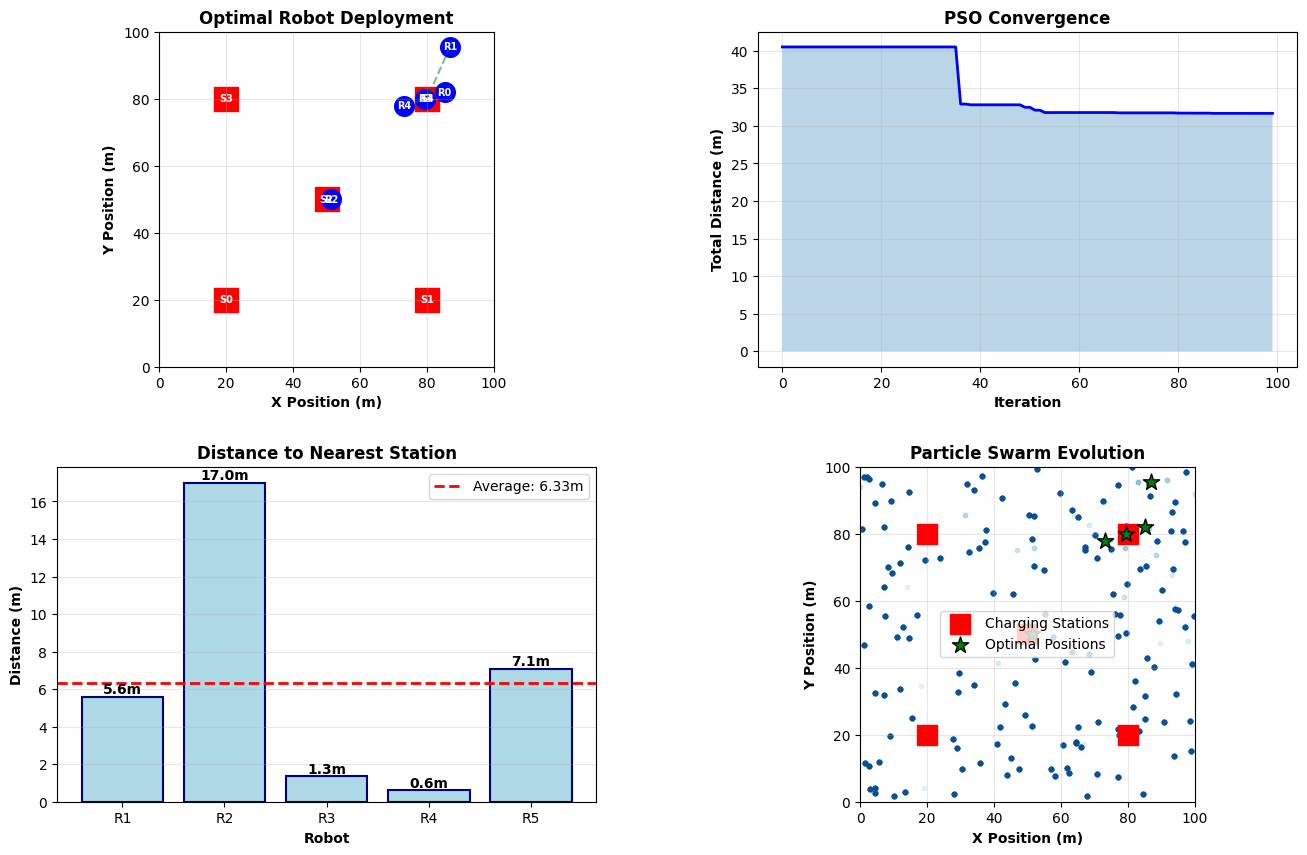

In [54]:
def visualize_robot_positioning(best_positions: np.ndarray,
                               stations: np.ndarray,
                               fitness_history: List[float],
                               swarm_history: List[np.ndarray]):
    """
    Visualize robot positioning optimization.
    """
    
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
    
    
    # Top-left: Warehouse layout
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_title('Optimal Robot Deployment', fontsize=12, fontweight='bold')
    
    #Charging stations
    ax1.scatter(stations[:, 0], stations[:, 1], color='red', s=300, marker='s')
    #Add a label for each station
    for i, (x, y) in enumerate(stations):
        ax1.text(x, y, f"S{i}", fontsize=7, fontweight='bold', color='white', ha='center', va='center')

    #Robot positions
    ax1.scatter(best_positions[:, 0], best_positions[:, 1], color='blue', s=200, marker='o')
    #Add a label for each robot
    for i, (x, y) in enumerate(best_positions):
        ax1.text(x, y, f"R{i}", fontsize=7, fontweight='bold', color='white', ha='center', va='center')

    for pos in best_positions:
        distances = np.sqrt(np.sum((pos - stations)**2, axis=1))

        nearest_idx = np.argmin(distances)
        print(nearest_idx)
        print(np.min(distances))
        print(stations[nearest_idx][0])

        ax1.plot([pos[0], stations[nearest_idx][0]], [pos[1], stations[nearest_idx][1]], 'g--', alpha=0.5)


    ax1.set_xlim(0, WAREHOUSE_SIZE)
    ax1.set_ylim(0, WAREHOUSE_SIZE)

    ax1.set_xlabel('X Position (m)', fontweight='bold')
    ax1.set_ylabel('Y Position (m)', fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_aspect('equal')
    
    # Top-right: Fitness convergence
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.set_title('PSO Convergence', fontsize=12, fontweight='bold')
    iterations = range(len(fitness_history))
    ax2.plot(iterations, fitness_history, 'b-', linewidth=2)
    ax2.set_xlabel('Iteration', fontweight='bold')
    ax2.set_ylabel('Total Distance (m)', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.fill_between(iterations, fitness_history, alpha=0.3)
    
    # Bottom-left: Distance distribution
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.set_title('Distance to Nearest Station', fontsize=12, fontweight='bold')
    
    distances_to_nearest = []
    for robot_pos in best_positions:
        distances = np.sqrt(np.sum((stations - robot_pos)**2, axis=1))
        distances_to_nearest.append(np.min(distances))
    
    robot_labels = [f'R{i+1}' for i in range(NUM_ROBOTS)]
    bars = ax3.bar(robot_labels, distances_to_nearest, color='lightblue', 
                   edgecolor='navy', linewidth=1.5)
    ax3.axhline(y=np.mean(distances_to_nearest), color='r', linestyle='--',
                linewidth=2, label=f'Average: {np.mean(distances_to_nearest):.2f}m')
    ax3.set_ylabel('Distance (m)', fontweight='bold')
    ax3.set_xlabel('Robot', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    for bar, dist in zip(bars, distances_to_nearest):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{dist:.1f}m', ha='center', va='bottom', fontweight='bold')
    
    # Bottom-right: Swarm evolution (show multiple snapshots)
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.set_title('Particle Swarm Evolution', fontsize=12, fontweight='bold')
    
    # Plot charging stations
    ax4.scatter(stations[:, 0], stations[:, 1], color='red', s=200, 
               marker='s', label='Charging Stations', zorder=3)
    
    # Plot swarm at different iterations with different colors
    colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(swarm_history)))
    for i, swarm_positions in enumerate(swarm_history):
        # Flatten all particle positions
        all_positions = swarm_positions.reshape(-1, 2)
        alpha = 0.3 + (i / len(swarm_history)) * 0.4
        ax4.scatter(all_positions[:, 0], all_positions[:, 1], 
                   color=colors[i], s=10, alpha=alpha)
    
    # Plot final best positions
    ax4.scatter(best_positions[:, 0], best_positions[:, 1], 
               color='green', s=150, marker='*', 
               label='Optimal Positions', zorder=4, edgecolor='black', linewidth=1)
    
    ax4.set_xlabel('X Position (m)', fontweight='bold')
    ax4.set_ylabel('Y Position (m)', fontweight='bold')
    ax4.set_xlim(0, WAREHOUSE_SIZE)
    ax4.set_ylim(0, WAREHOUSE_SIZE)
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    ax4.set_aspect('equal')
    
    plt.show()

# Create visualization
visualize_robot_positioning(best_robot_positions, charging_stations, 
                           fitness_history, swarm_history)